# Deep Learning Exam  A.Y. 23/24 - 05/06/24
## Antonio Rapallini mat. 0001093767


# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


Download the dataset

In [2]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
np.random.seed(42)
ds = load_dataset('generics_kb',trust_remote_code=True)['train']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Filter row with length greater than 8.


In [3]:
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8 )
corpus = [ '<start> ' + row['generic_sentence'].replace(","," <comma>") + ' <end>' for row in ds ]
corpus = np.array(corpus)


Filter:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Create a tokenizer and Detokenizer

In [4]:
tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8",) #con il max prende le piu frequenti. ordina i token del vocab dal piu frequente al meno frequente
tokenizer.adapt(corpus)

class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s="<start>"
          elif t == 2:
            s="<end>"
          elif t == 7:
            s="<comma>"
          else:
            s=self.index_to_word.get(t, '[UNK]')
          return s

        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]


detokenizer = TextDetokenizer( tokenizer )
sentences = tokenizer( corpus ).numpy()

Remove from corpus the sentences where any unknow word appears

In [5]:
mask = np.sum( (sentences==1), axis=1) >= 1
original_data = np.delete( sentences, mask , axis=0)

In [6]:
original_data.shape

(241236, 28)

Shuffle the sentences

In [7]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
          np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        return data_batch , result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

In [8]:
# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

In [9]:
#split the dataset
train_generator = DataGenerator(shuffled_data[:220000])
test_generator = DataGenerator(shuffled_data[220000:])

In [10]:
x, y = test_generator.__getitem__(1)
x = detokenizer(x)
y = detokenizer(y)

for i in range(7):
  print("original: ", y[i])
  print("shuffled: ", x[i])
  print("\n")


original:  <start> ranchers clear large areas of rainforest to become pastures for their cattle <end>
shuffled:  <start> large their areas for cattle ranchers rainforest clear pastures become to of <end>


original:  <start> some earwigs have stripes on the thorax and abdomen <end>
shuffled:  <start> stripes thorax some and the earwigs on abdomen have <end>


original:  <start> magnetic manipulation can turn molecules in a liquid into computing such devices <end>
shuffled:  <start> into in magnetic such a liquid molecules can manipulation computing turn devices <end>


original:  <start> healthy wetlands means cleaner water <comma> reduced flooding and more places for recreation <end>
shuffled:  <start> reduced wetlands and recreation for water places healthy cleaner flooding <comma> means more <end>


original:  <start> market share is the percent share in sales one company controls in a particular market <end>
shuffled:  <start> company percent share one controls a sales in market is

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [11]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(p),len(s)))

Let's do an example.

In [12]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

Reading some papers and doing some research on the web led me to the creation of several models.
Several architectures widely used in text translation were then tested.

- **Encoder/Decoder model based on LSTM** with attention mechanism and teacher forcing technique as presented in the paper [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)

- **Transformer** made based on the architecture presented within the iconic paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

- **DoubleTransformer** a customized variant composed of two single transformers to which modifications have been made. This architecture was taken from the book "Deep Learning with Tensorflow and Keras" by Kapoor, Gulli, and Pal.

The last one was the model used for this assignement.

## Imports

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import numpy as np
import tensorflow as tf
import random
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import Random

from keras.models import Model
from keras.layers import MultiHeadAttention, LayerNormalization, Dense, Layer, Dropout, Embedding
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Creating Sets

In [15]:
training_set_size = 220000

# creating a full training and test set
x_train, y_train =DataGenerator(shuffled_data[:220000], batch_size=training_set_size).__getitem__(0)
x_test, y_test = DataGenerator(shuffled_data[220000:], batch_size=original_data.shape[0]-220000).__getitem__(0)

### Data Augumentation

To perform data augmentation, both the original set of sentences and the set of shuffled sentences will be duplicated. However, while the new set of original sentences remains unchanged, the set of shuffled sentences will be reshuffled. This way, each original sentence will have two differently shuffled versions associated with it, effectively doubling the amount of data, without using any additional data from other datasets.

In [16]:
def augmented_data(y_train, x_train):
    original_y = y_train.copy()
    mixed_sentence = np.copy(x_train)
    for i in range(x_train.shape[0]):
        # Find word indices for each sentence
        indices = np.where((x_train[i] != 0) & (x_train[i] != 2) & (x_train[i] != 3))[0]
        # Generate random indices for shuffling within sentences
        rand_idx = np.copy(indices)
        random.shuffle(rand_idx)
        mixed_sentence[i,indices] = [x_train[i][rand_idx]]

    x_train = np.concatenate((x_train, mixed_sentence), axis=0)
    y_train = np.concatenate((y_train, original_y), axis=0)
    return y_train, x_train

y_train, x_train = augmented_data(y_train, x_train)

## Hyperparameter

While building the model, at the two transformers were given their own set of hyperparameters to explore all tuning options. However, during testing, it was realized that the best results came when the two transformers were set up identically.


In [17]:
VOCABULARY_SIZE = 10000

# Training Parameter
N_EPOCHS = 25
BATCH_SIZE= 128
VALIDATION_SPLIT = .2

# Beam serch parameter
BEAM_SIZE = 5


# Model Parameter
transformer_1_params = {
    "num_layers" : 4,                               # number of layers
    "d_model" : 128,                                # embedding dimension
    "num_heads" : 7,                                # nmber of heads
    "dff" : 254,                                    # feed forward dimension
    "input_vocab_size" : VOCABULARY_SIZE,
    "output_vocab_size" : VOCABULARY_SIZE,
    "dropout_rate" : 0.15,                          # dropout rate
    "encoder_type" : 'not-positional'
}

transformer_2_params = {
    "num_layers" : 4,                               # number of layer
    "d_model" : 128,                                # embedding dimension
    "num_heads" : 7,                                # nmber of heads
    "dff" : 254,                                    # feed forward dimension
    "input_vocab_size" : VOCABULARY_SIZE,
    "output_vocab_size" : VOCABULARY_SIZE,
    "dropout_rate" : 0.15,                          # dropout rate
    "encoder_type" : 'not-positional'
}

## Model Definition

As mentioned earlier, the proposed model consists of two Transformers.

This idea was born thinking that the model could perform better by training the two transformers on two different shuffles of the same sentence and combining the results through a linear operation. This aspect then made it necessary to perform a data augmentation operation that for each original sentence would generate two different shuffles.


The second insight that led to the realization of this architecture is that the model does not need to give importance to the order of the shuffled sentences during encoding. It was therefore chosen to deprive the Encoders within each Transformer of Positional Embedding.




### Positional Embedding

In [18]:
# Define the encodings

def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]        # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth      # (1, depth)

  angle_rates = 1 / (10000**depths)                   # (1, depth)
  angle_rads = positions * angle_rates                # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)],
                                axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)


class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = Embedding(vocab_size,
                               d_model,
                               mask_zero=True)

    self.pos_encoding = positional_encoding(length=2048,
                                            depth=d_model)


  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


class ClassicalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = Embedding(vocab_size,
                               d_model,
                               mask_zero=True)


  def call(self, x):
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

    return x

### Attention Block

In [19]:
# Define the Attention
class Attention(Layer):
  def __init__(self, num_heads, key_dim, dropout_rate):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.normalization = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout_rate)

  def call(self, query, value, key, casual_mask=False, training=True):
        attn_output = self.mha(query=query, value=value, key=key, use_causal_mask=casual_mask, training=training)
        attn_output = self.dropout(attn_output, training=training)
        #Add & Normalization
        out = self.normalization(query + attn_output)
        return out

### FeedForward Block

In [20]:
# Define the Feed Forword
class FeedForward(Layer):
  def __init__(self, d_model, dff, dropout_rate):
        super().__init__()
        self.first_dense = Dense(dff, activation='relu')
        self.second_dense = Dense(d_model, activation='relu')
        self.norm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout_rate)

  def call(self, x, training=True):
        fd = self.first_dense(x)
        sd = self.second_dense(fd)
        output = self.dropout(sd, training=training)
        #Add & Normalization
        output = self.norm(x + output)
        return output

### Encoder Layer

In [21]:
# Define the Encoder layer
class EncoderLayer(Layer):

    def __init__(self, d_model, num_heads, dff, dropout_rate):
        super().__init__()
        self.self_attetion = Attention(num_heads=num_heads, key_dim=d_model, dropout_rate=dropout_rate)
        self.feed_forward = FeedForward(d_model, dff, dropout_rate)

    def call(self, x, training=True):
        attn_output = self.self_attetion(query=x, value=x, key=x, training=training)
        ffn_output = self.feed_forward(attn_output)
        return ffn_output

### Encoder Block

In [22]:
# Define the Encoder
class Encoder(Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate, embedding_type):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        if embedding_type == 'positional':
          self.embedding = PositionalEmbedding(input_vocab_size, d_model)
        else:
           self.embedding =  ClassicalEmbedding(input_vocab_size, d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]
        self.dropout = Dropout(dropout_rate)

    def call(self, x, training=True):
        # x is shape: (batch, seq_len)
        x = self.embedding(x)                     # (batch_size, seq_len, d_model)
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training)

        return x      # (batch_size, seq_len, d_model)


### Decoder Layer

In [23]:
# Define the Decoder layer
class DecoderLayer(Layer):

    def __init__(self, d_model, num_heads, dff, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.self_attention = Attention(num_heads=num_heads, key_dim=d_model, dropout_rate=dropout_rate)
        self.mha = Attention(num_heads=num_heads, key_dim=d_model, dropout_rate=dropout_rate)
        self.feed_forward = FeedForward(d_model, dff, dropout_rate)


    def call(self, x, enc_output, training=True):
        self_attention = self.self_attention(query=x, value=x, key=x, casual_mask=True, training=training)
        multi_head_attention = self.mha(query=self_attention, value=enc_output, key=enc_output, training=training)
        ffn_output = self.feed_forward(multi_head_attention)    # (batch_size, seq_len, d_model)

        return ffn_output

### Decoder Block

In [24]:
# Define the Decoder
class Decoder(Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, dropout_rate):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_encoding = PositionalEmbedding(target_vocab_size, d_model)
        self.dropout = Dropout(dropout_rate)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]

    def call(self, x, enc_output, training=True):
        # x is shape (batch, target_seq_len)
        x = self.pos_encoding(x)                  # (batch_size, target_seq_len, d_model)
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, training=training)

        return x      # (batch_size, target_seq_len, d_model)

### Metrics

In [25]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps


  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

def masked_loss(label, pred):
  mask = label != 0
  loss_object = SparseCategoricalCrossentropy(
    from_logits=False, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)


### Single Transformer

In [26]:
class Transformer(Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, output_vocab_size, dropout_rate, encoder_type):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate, encoder_type)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, output_vocab_size, dropout_rate)
        self.final_layer = Dense(output_vocab_size, activation='softmax')

    def call(self, input, training=True):
        context, input_sentence = input
        encoder_output = self.encoder(context, training=training)                              # (batch_size, context_len, d_model)
        decoder_output = self.decoder(input_sentence, encoder_output, training=training)       # (batch_size, target_len, d_model)
        final_output = self.final_layer(decoder_output)                                        # (batch_size, target_len, vocab_size)
        try:
          del final_output._keras_mask
        except AttributeError:
          pass

        return final_output

### Double transformer

This block consists of two Transformers that working in parallel cooperate to efficiently reorder the input sentences.
During the various stages of testing a few different types of optimizer were tried, however, it was found that Adam was the most effective.

In [27]:
class DoubleTransformer(Model):
  def __init__(self, transformer_1_params, transformer_2_params, output_shape):
    super().__init__()
    self.transformer_1 = Transformer(**transformer_1_params)
    self.transformer_2 = Transformer(**transformer_2_params)

  def call(self, input, training=True):
    output_model_1 = self.transformer_1(input, training = training)
    output_model_2 = self.transformer_2(input, training = training)
    return output_model_1 + output_model_2

  def compile(self, lr_1, lr_2):
    learning_rate_1 = CustomSchedule(lr_1)
    learning_rate_2 = CustomSchedule(lr_2)

    optimizer_1 = Adam(learning_rate_1, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
    optimizer_2 = Adam(learning_rate_2, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

    self.transformer_1.compile(loss=masked_loss,
                               optimizer=optimizer_1,
                               metrics=[masked_accuracy])

    self.transformer_2.compile(loss=masked_loss,
                               optimizer=optimizer_2,
                               metrics=[masked_accuracy])


  def save(self, path1, path2):
    self.transformer_1.save_weights(path1)
    self.transformer_2.save_weights(path2)

  def load(self, path1, path2):
    self.transformer_1.load_weights(path1)
    self.transformer_2.load_weights(path2)

  # A customized training method that makes the two transformers train separately
  def fit(self, x, y, validation_split = .1, epochs=6, batch_size=256, callbacks_1=[], callbacks_2=[]):
    x1, x2 = x
    data_size = x1.shape[0]

    print('-'*200)
    print("training transformer 1:")
    print('-' * 200)
    history1 = self.transformer_1.fit([x1[:data_size//2],
                                      x2[:data_size//2]],
                                      y[:data_size//2],
                                      epochs=epochs,
                                      batch_size=batch_size,
                                      validation_split=validation_split,
                                      callbacks=callbacks_1
                                      )
    print('-'*200)
    print("training transformer 2:")
    print('-' * 200)
    history2 = self.transformer_2.fit([x1[data_size//2:],
                                       x2[data_size//2:]],
                                       y[data_size//2:],
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       validation_split=validation_split,
                                       callbacks=callbacks_2
                                      )

    return history1, history2


## Model Creation

In [28]:
my_d_t = DoubleTransformer(transformer_1_params, transformer_2_params, VOCABULARY_SIZE)
my_d_t([y_train[:1], x_train[:1]])
my_d_t.compile(128, 128) # (d_model, d_model)

my_d_t.summary()

Model: "double_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (Transformer)   multiple                  9917184   
                                                                 
 transformer_1 (Transformer  multiple                  9917184   
 )                                                               
                                                                 
Total params: 19834368 (75.66 MB)
Trainable params: 19834368 (75.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Fitting the model

In [ ]:
train = True

path_folder = '/content/drive/My Drive/weights'

path_weigth1 = os.path.join(path_folder, 'best_weights_t1_5.weights.h5')
path_weigth2 = os.path.join(path_folder, 'best_weights_t2_5.weights.h5')

if train:
  # Definition of the callbacks that save the best weigths

  checkpoint_callback_1 = ModelCheckpoint(filepath=path_weigth1,
                                          monitor='val_loss',
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='min',
                                          verbose=1
                                        )

  checkpoint_callback_2 = ModelCheckpoint(filepath=path_weigth2,
                                          monitor='val_loss',
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='min',
                                          verbose=1
                                        )


  # Definition of the callbacks that stop the trainin process if  for 5 epochs the  val_loss dont decreas at last of 0.0009

  early_stopping_1 = EarlyStopping(monitor='val_loss',           # Metric to monitor
                                patience=5,                      # Number of consecutive epochs without improvement
                                restore_best_weights=True,       # Restore weights of the best epoch
                                mode='min',                      # minimizing
                                min_delta=0.001,                 # minimum change between two epochs
                                verbose=1
                                )

  early_stopping_2 = EarlyStopping(monitor='val_loss',           # Metric to monitor
                                patience=5,                      # Number of consecutive epochs without improvement
                                restore_best_weights=True,       # Restore weights of the best epoch
                                mode='min',                      # minimizing
                                min_delta=0.001,                 # minimum change between two epochs
                                verbose=1
                                )



  history_1, history_2 = my_d_t.fit([x_train, y_train[:,:-1]],
                                    y_train[:,1:],
                                    epochs=N_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_split = VALIDATION_SPLIT,
                                    callbacks_1=[early_stopping_1, checkpoint_callback_1],
                                    callbacks_2=[early_stopping_2, checkpoint_callback_2]
                                   )
else:
  my_d_t.load('/content/drive/My Drive/weights/best_weights_t1_5.weights.h5',
              '/content/drive/My Drive/weights/best_weights_t2_5.weights.h5')

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
training transformer 1:
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/25
1375/1375 [==============================] - ETA: 0s - loss: 5.9489 - masked_accuracy: 0.2723
Epoch 1: val_loss improved from inf to 3.65194, saving model to /content/drive/My Drive/weights/best_weights_t1_final1.weights.h5
1375/1375 [==============================] - 154s 93ms/step - loss: 5.9489 - masked_accuracy: 0.2723 - val_loss: 3.6519 - val_masked_accuracy: 0.4868
Epoch 2/25
1375/1375 [==============================] - ETA: 0s - loss: 2.6484 - masked_accuracy: 0.5793
Epoch 2: val_loss improved from 3.65194 to 1.71830, saving model to /content/drive/M

## Plotting the training process

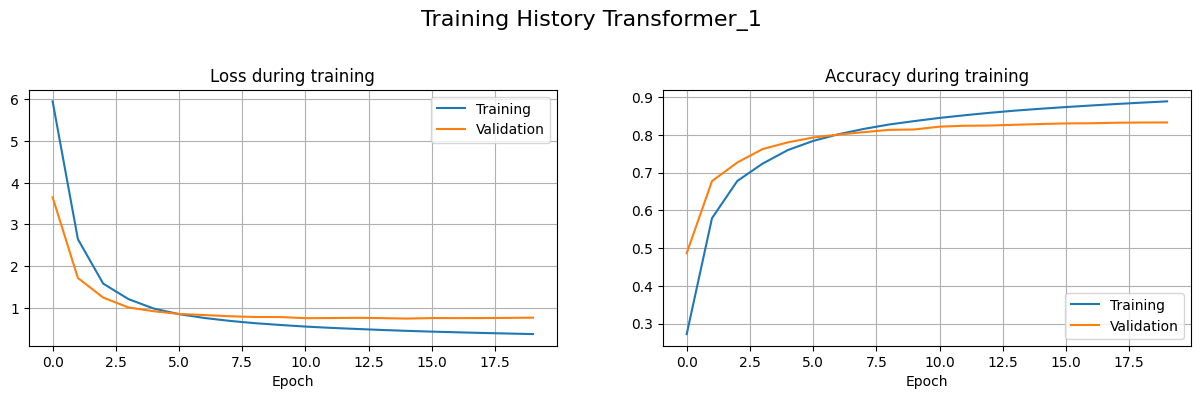

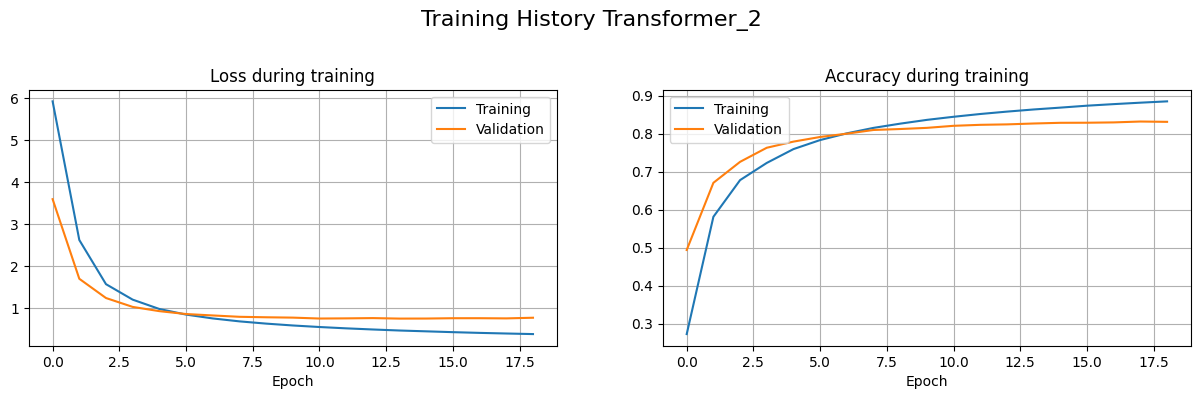

In [ ]:
def display_history(model_fit, model_name):
    print(model_fit)
    mse_training = model_fit.history['loss']
    acc_training = model_fit.history['masked_accuracy']

    mse_val = model_fit.history['val_loss']
    acc_val = model_fit.history['val_masked_accuracy']

    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

    axs[0].plot(mse_training)
    axs[0].plot(mse_val)
    axs[0].grid()
    axs[0].set_title('Loss during training')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Training', 'Validation'])

    axs[1].plot(acc_training)
    axs[1].plot(acc_val)
    axs[1].grid()
    axs[1].set_title('Accuracy during training')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Training', 'Validation'])

    fig.text(0.5, 0.95, 'Training History ' + model_name, ha='center', va='top', fontsize=16)
    fig.subplots_adjust(top=0.75)

    plt.show()

display_history(history_1, 'Transformer_1')
display_history(history_2, 'Transformer_2')


The charts indicate that the validation test's loss and accuracy closely track the training values, with only a minor discrepancy. There are no significant signs of Overfitting observed.

## Test the Model

The realized model generates sentences one token at a time by basing the generation of a new token on the previous one.
The choice of this token can be made through several strategies, the one used here is:

- **GreedySearch**: simple implementation and high performance from the point of view of computational complexity

This technique generates each token by extracting the one with the highest probability of being associated with the previous token, from the list of probabilities assigned to each token given in output by the model.

### Gready Search  Definition

In [29]:
def greedySearch(input_sequence, masking=True):
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, 3)
    stop_condition = False

    for i in range(28):
      output = tf.transpose(output_array.stack())
      output = output.numpy().reshape((1,output.shape[0]))
      predictions = my_d_t([input_sequence, output], training=False)
      predictions = predictions[0, -1:, :]
      predictions = predictions.numpy()
      predicted_id = tf.argmax(predictions, axis=-1)
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == 2:
        break

    output = tf.transpose(output_array.stack())
    return output.numpy()

In [30]:
def convert_sequence(input_sequence):
  mask = [0, 1, 2, 3]
  input_sequence = np.array(input_sequence)
  input_sequence = input_sequence[~np.isin(input_sequence, mask)]
  input_sequence = detokenizer([input_sequence])
  return input_sequence

### Comparison between GreedySearch and Target Sentence

An initial test case was chosen by going to consider a small set of number of items so that the quality of sentence reconstruction through the Greedy Search technique could be verified visually.


In [31]:
nbr_sents_2_test = 50

scores_vector_beam_seach = []
scores_vector_arg_max = []

for i in range(nbr_sents_2_test):
  print('-'*200)
  print(i, "/", nbr_sents_2_test)

  print('Index phrase:', i)
  s = convert_sequence(y_test[i])[0].replace(' <comma>', ',')

  print("Target sequence      :", s)

  p = convert_sequence(greedySearch(x_test[i].reshape(1,28), VOCABULARY_SIZE))[0].replace(' <comma>', ',')
  print("Predict sequence arg :", p)
  sco_argmax = score(p,s)

  print("Score with arg max:    ", sco_argmax)

  scores_vector_arg_max.append(sco_argmax)


my_score_argmax = np.mean(scores_vector_arg_max)

print('=' * 200)
print("Final Score armax:", my_score_argmax)


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0 / 50
Index phrase: 0
Target sequence      : recycling prevents pollution and helps conserve precious natural resources
Predict sequence arg : recycling helps conserve pollution and prevents precious natural resources
Score with arg max:     0.36486486486486486
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1 / 50
Index phrase: 1
Target sequence      : predators like to eat banana slugs at all stages of their lives
Predict sequence arg : predators like to eat banana slugs at all stages of their lives
Score with arg max:     1.0
--------------------------------------------------------------------------------------------------------------

### Final Test  

A more general test case was chosen considering a set of 3000 sentences to be reordered to produce the required score.
The test was carried out to highlight the performance achieved by the model using Greedy Search with a big load of data.

#### Final results GreedySearch

The following is the result obtained by applying the GreedySearch

In [ ]:
# This function has been implemented in order to speed up the test
def predictBatch(input_sequences):
        batch_size = input_sequences.shape[0]
        encoder_input = input_sequences
        decoded_indexes = [[3] for _ in range(batch_size)]

        for i in range(1, 28):
            decoder_input = tf.convert_to_tensor(decoded_indexes)

            predictions = np.array(my_d_t([encoder_input, decoder_input], training=False))
            predictions = predictions[:, -1, :]
            sampled_token_index = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

            for ind in range(batch_size):
              decoded_indexes[ind].append(int(sampled_token_index[ind]))


        return decoded_indexes

In [ ]:
total_score = 0
num_examples = 3000
start_id = 0
batch = 500
# Instantiate the Random instance with random seed = 42 to ensure reproducibility
randomizer = Random(42)

possible_choice = [i for i in range(len(x_test))]
random.shuffle(possible_choice)
predicted_sequences_tot = []

for i in tqdm(range(start_id, (start_id+num_examples)//batch)):
  begin = i*batch
  end = (i+1)*batch

  predicted_sequences = predictBatch(x_test[possible_choice[begin:end]])
  predicted_sequences_tot += predicted_sequences


for i in (range(start_id, start_id+num_examples)):
    original_sentence = detokenizer([y_test[possible_choice[i]]])[0].replace(' <comma>', ',').replace('<start> ', '').replace(' <end>', '')

    prediction = predicted_sequences_tot[i]
    if(2 in prediction):
      end_token_index = prediction.index(2)
      prediction = prediction[:end_token_index+1]

    predicted_sentence = detokenizer([prediction])
    predicted_sentence = predicted_sentence[0].replace(' <comma>', ',').replace('<start> ', '').replace(' <end>', '')

    total_score += score(predicted_sentence, original_sentence)

arg_max_score = (total_score / num_examples)


print('\n======================================================================')
print("|               FINAL SCORE:                     ", arg_max_score   ,"|")
print('======================================================================')

100%|██████████| 6/6 [01:30<00:00, 15.09s/it]



|               FINAL SCORE:                      0.5247153361025779 |


## Conclusion

In the first evaluation, which included 50 sentences, a minor value in the score was noted (0.4807611319573617), for the concluding evaluation, carried out with 3000 sentences as specified, GreedySearch showed a marginally superior performance.


**MY BEST SCORE**
---

**0.5267747631933689**.

---

